# P1. Exploration

## 1. Description Générale

En utilisant DBeaver et les paramètres de connexion donnés par ailleurs, faire une description détaillée de la base de données fournie. Présenter notamment le diagramme entité - relation (ERD) et les différentes caractéristiques des tables de la base.  Quelles types de renseignement peut-on tirer de cette base de données ?   

La structure de la base de données Chinook est composée de 11 tables :

employees       - PK EmployeeId         - FK employees(EmployeeId) / employees(ReportsTo) 1, *

customers       - PK CustomerId         - FK employees(EmployeeId) / customers(SupportRepId) 1, *

invoices        - PK InvoiceID          - FK customers(CustomerId) / invoices(CustomerId) 1, *

invoice_items   - PK InvoiceLineId      - FK invoices(InvoiceId) / invoice_items(InvoiceId) 1, *
                                    and - FK tracks(TrackId) / invoice_items(TrackId) 1, *
                               
tracks          - PK TrackId            - FK albums(AlbumId) / tracks(AlbumId) 1, *
                                    and - FK genres(GenreId) / tracks(GenreId) 1, *
                                    and - FK media_types(MediaTypeId) / tracks(MediaTypeId) 1, *
                                    and - FK playlist_track(TrackId) / tracks(TrackId) 0, 1
                                    and - FK invoice_items(TrackId) / tracks(TrackId) 1, *
                               
albums          - PK AlbumId            - FK artists(ArtistId) / albums(ArtistId) 1, *

genres          - PK GenreId            - FK tracks(GenreId) / genres(GenreId) 1, *

artists         - PK ArtistId           - FK albums(ArtistId) / artists(ArtistId) 1,*

media_types     - PK MediaTypeId        - FK tracks(MediaTypeId) / media_types(MediaTypeId) 1,*

playlist_track  - PK PlayListId+TrackId - FK playlists(PlaylistId) / playlist_track(PlaylistId)
                                    and - FK tracks(TrackId) / playlist_track(TrackId)

playlist        - PK PlaylistId         - FK playlist_track(PlaylistId) / FK playlists(PlaylistId)

On peut considérer que la table centrale est tracks et on peut remonter invoices > customers > employees via invoice_items.

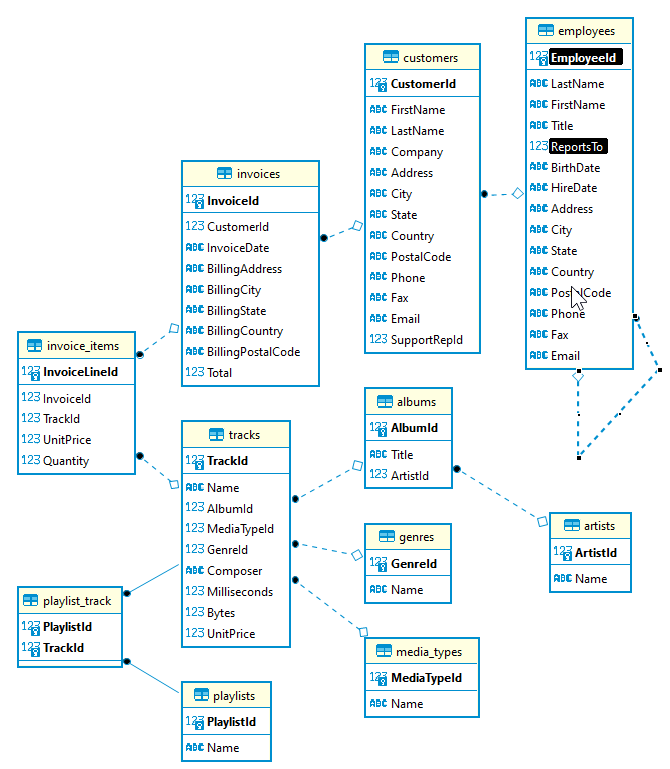

In [2]:
from IPython.display import Image
Image("Img/ERD.png")

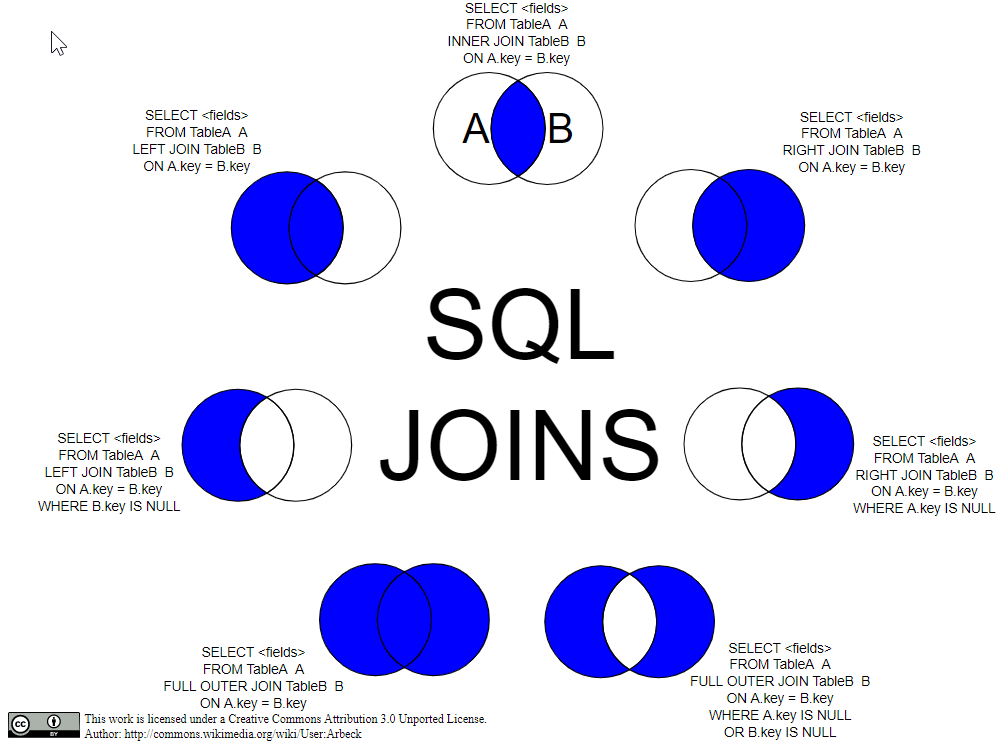

In [3]:
from IPython.display import Image
Image("Img/SQL_JOINS.png")

---

## 2. Exploration SQL via python / pandas
Dans cette partie, on s'attache à explorer la base de données en utilisant le language SQL pour les requêtes et le language Python (+ module pandas) pour récupérer les résultats de façon programmatique.  
Vous pouvez utiliser DBeaver ou outil similaire pour préparer / tester vos requêtes mais celles-ci doivent être reportées et appliquées dans du code Python comme présenté dans les quelques examples à suivre.  
*Pour les résultats "longs", un aperçu des quelques premières lignes et le comptage total des résultats est suffisant.*

In [3]:
import os
import sqlite3
import pandas as pd   

In [4]:
from pathlib import Path

In [5]:
# Ouvre connection vers SQLite db
chemin_bdd = Path('db') / 'chinook.db'
conn = sqlite3.connect(chemin_bdd)

In [6]:
chemin_bdd

WindowsPath('db/chinook.db')

### Organigramme Compagnie

Q01. Ecrivez et exécutez une unique requête listant chaque employée de la compagnie (Id, nom + prénom, Titre) ainsi que son manager direct (nom + prénom, Titre)

In [5]:
# requête de départ
query = """
    SELECT e.EmployeeId AS 'Id',
           e.firstname || ' ' || e.lastname AS 'Employee'
    FROM employees e;
"""

In [6]:
results = pd.read_sql_query(query, conn)
results

,Id,Employee
0,1,Andrew Adams
1,2,Nancy Edwards
2,3,Jane Peacock
3,4,Margaret Park
4,5,Steve Johnson
5,6,Michael Mitchell
6,7,Robert King
7,8,Laura Callahan


In [7]:
# requête complétée
query = """
    SELECT e.EmployeeId AS 'Id',
	   e.Title,
       e.firstname || ' ' || e.lastname AS 'Employee',
       e.ReportsTo AS 'Reports to',
       m.Title,
       m.FirstName || ' ' || m.LastName AS 'Manager'
    FROM employees as e
    LEFT JOIN employees as m ON e.ReportsTo = m.EmployeeId 
    ORDER BY Manager;
"""

In [8]:
results = pd.read_sql_query(query, conn)
results

,Id,Title,Employee,Reports to,Title,Manager
0,1,General Manager,Andrew Adams,NaN,None,None
1,2,Sales Manager,Nancy Edwards,1.0,General Manager,Andrew Adams
2,6,IT Manager,Michael Mitchell,1.0,General Manager,Andrew Adams
3,7,IT Staff,Robert King,6.0,IT Manager,Michael Mitchell
4,8,IT Staff,Laura Callahan,6.0,IT Manager,Michael Mitchell
5,3,Sales Support Agent,Jane Peacock,2.0,Sales Manager,Nancy Edwards
6,4,Sales Support Agent,Margaret Park,2.0,Sales Manager,Nancy Edwards
7,5,Sales Support Agent,Steve Johnson,2.0,Sales Manager,Nancy Edwards


Q02. Pour chaque artiste présent dans cette BDD, indiquez le nombre d'albums de cet artiste également répertorié (Liste triée par nom d'artiste)


In [33]:
query = """
SELECT DISTINCT ar.ArtistId,
	   ar.Name,
	   COUNT(al.Title) AS 'Nombre de Titres' 
    FROM artists as ar
    INNER JOIN albums as al ON ar.ArtistId = al.ArtistId
    GROUP BY ar.ArtistId
    ORDER BY ar.Name;
"""

In [34]:
results = pd.read_sql_query(query, conn)
results

,ArtistId,Name,Nombre de Titres
0,1,AC/DC,2
1,230,Aaron Copland & London Symphony Orchestra,1
2,202,Aaron Goldberg,1
3,214,Academy of St. Martin in the Fields & Sir Nevi...,1
4,215,Academy of St. Martin in the Fields Chamber En...,1
...,...,...,...
199,72,Vinícius De Moraes,1
200,211,Wilhelm Kempff,1
201,255,Yehudi Menuhin,1
202,212,Yo-Yo Ma,1


Q03. Produire une liste des albums reprenant également l'artiste de l'album, le nombre de pistes, la durée de toutes les pistes (en minutes) et le coût total (Liste triée par artiste puis nom d'album)


In [14]:
query = """
SELECT 
		al.Title as 'Titre album',
		ar.Name as 'Artistes', 
		COUNT(t.TrackId) as 'Nombre de pistes',
		SUM(t.Milliseconds)/60000. as 'Durée Totale en Minutes',
		SUM(t.UnitPrice) as 'Prix Total Album'
	FROM albums al
		INNER JOIN artists ar ON al.ArtistId = ar.ArtistId 
			LEFT JOIN tracks t ON al.AlbumId = t.AlbumId
	GROUP BY Title
	ORDER BY Artistes, Title;
"""

In [15]:
results = pd.read_sql_query(query, conn)
results

,Titre album,Artistes,Nombre de pistes,Durée Totale en Minutes,Prix Total Album
0,For Those About To Rock We Salute You,AC/DC,10,40.006917,9.90
1,Let There Be Rock,AC/DC,8,40.887650,7.92
2,"A Copland Celebration, Vol. I",Aaron Copland & London Symphony Orchestra,1,3.301067,0.99
3,Worlds,Aaron Goldberg,1,4.448933,0.99
4,The World of Classical Favourites,Academy of St. Martin in the Fields & Sir Nevi...,2,7.753350,1.98
...,...,...,...,...,...
342,Vinicius De Moraes,Vinícius De Moraes,15,54.245350,14.85
343,Bach: Goldberg Variations,Wilhelm Kempff,1,2.007717,0.99
344,Bartok: Violin & Viola Concertos,Yehudi Menuhin,1,4.989167,0.99
345,Bach: The Cello Suites,Yo-Yo Ma,1,2.388133,0.99


Q04. Produire une liste des toutes les playlists reprenant son nom, le nombre de pistes, la durée de toutes les pistes (en minutes) et le coût total (Liste triée par nom de playlist)


In [22]:
query= """
SELECT 
		p.PlaylistId as 'ID Playlist',
		p.Name as 'Nom Playlist',
		COUNT(pt.TrackId) as 'Nombre de pistes',
		SUM(t.Milliseconds)/60000 as 'Durée Totale en Minutes',
		SUM(t.UnitPrice) as 'Prix Total Playlist'
	FROM playlists p
		LEFT JOIN playlist_track pt ON p.PlaylistId = pt.PlaylistId 
			LEFT JOIN tracks t ON pt.TrackId = t.TrackId 
	GROUP BY p.PlaylistId, p.Name
    ORDER BY p.Name;
"""

In [23]:
results = pd.read_sql_query(query, conn)
results

,ID Playlist,Nom Playlist,Nombre de pistes,Durée Totale en Minutes,Prix Total Playlist
0,5,90’s Music,1477,6645.0,1462.23
1,4,Audiobooks,0,NaN,NaN
2,6,Audiobooks,0,NaN,NaN
3,11,Brazilian Music,39,158.0,38.61
4,12,Classical,75,362.0,74.25
5,13,Classical 101 - Deep Cuts,25,112.0,24.75
6,14,Classical 101 - Next Steps,25,126.0,24.75
7,15,Classical 101 - The Basics,25,123.0,24.75
8,16,Grunge,15,68.0,14.85
9,17,Heavy Metal Classic,26,136.0,25.74


Q05. Produire une liste des tous les genres de musique reprenant son genre, le nombre de pistes, la durée de toutes les pistes (en minutes), le coût total et le coût moyen (Liste triée par nom de genre)


In [24]:
query = """
SELECT 
		g.GenreId as 'ID Genre',
		g.Name as 'Genre',
		COUNT(t.TrackId) as 'Nombre de pistes',
		SUM(t.Milliseconds)/60000 as 'Durée Totale en Minutes',
		SUM(t.UnitPrice) as 'Prix Total par Genre',
		AVG(t.UnitPrice) as 'Coût moyen par Genre'
	FROM genres g
		LEFT JOIN tracks t ON g.GenreId = t.GenreId
	GROUP BY g.GenreId, g.Name
	ORDER BY g.Name;
"""

In [25]:
results = pd.read_sql_query(query, conn)
results

,ID Genre,Genre,Nombre de pistes,Durée Totale en Minutes,Prix Total par Genre,Coût moyen par Genre
0,23,Alternative,40,176,39.60,0.99
1,4,Alternative & Punk,332,1296,328.68,0.99
2,6,Blues,81,364,80.19,0.99
3,11,Bossa Nova,15,54,14.85,0.99
4,24,Classical,74,362,73.26,0.99
5,22,Comedy,17,449,33.83,1.99
6,21,Drama,64,2746,127.36,1.99
7,12,Easy Listening,24,75,23.76,0.99
8,15,Electronica/Dance,30,151,29.70,0.99
9,13,Heavy Metal,28,138,27.72,0.99


Q06. Indiquez les caractéristiques principales de toutes les pistes correspondant au genre 'Science Fiction' (nom de piste, album, artiste de l'album, compositeur, nom du type de media, durée (en secondes) et prix unitaire


In [26]:
query = """
SELECT t.Name,
		al.Title,
		ar.Name,
		t.Composer,
		mt.Name,
		(t.Milliseconds)/1000 AS 'Durée en Secondes',
		t.UnitPrice 
	FROM tracks t
		LEFT JOIN albums al ON t.AlbumId = al.AlbumId 
			LEFT JOIN artists ar ON al.ArtistId = ar.ArtistId 
				LEFT JOIN genres g ON t.GenreId = g.GenreId 
					LEFT JOIN media_types mt ON t.MediaTypeId = mt.MediaTypeId
	WHERE g.Name = 'Science Fiction';
"""

In [27]:
results = pd.read_sql_query(query, conn)
results

,Name,Title,Name,Composer,Name,Durée en Secondes,UnitPrice
0,Battlestar Galactica: The Story So Far,Battlestar Galactica: The Story So Far,Battlestar Galactica,None,Protected MPEG-4 video file,2622,1.99
1,A Measure of Salvation,"Battlestar Galactica, Season 3",Battlestar Galactica,None,Protected MPEG-4 video file,2563,1.99
2,Hero,"Battlestar Galactica, Season 3",Battlestar Galactica,None,Protected MPEG-4 video file,2713,1.99
3,Unfinished Business,"Battlestar Galactica, Season 3",Battlestar Galactica,None,Protected MPEG-4 video file,2622,1.99
4,The Passage,"Battlestar Galactica, Season 3",Battlestar Galactica,None,Protected MPEG-4 video file,2623,1.99
5,The Eye of Jupiter,"Battlestar Galactica, Season 3",Battlestar Galactica,None,Protected MPEG-4 video file,2618,1.99
6,Rapture,"Battlestar Galactica, Season 3",Battlestar Galactica,None,Protected MPEG-4 video file,2624,1.99
7,Taking a Break from All Your Worries,"Battlestar Galactica, Season 3",Battlestar Galactica,None,Protected MPEG-4 video file,2624,1.99
8,The Woman King,"Battlestar Galactica, Season 3",Battlestar Galactica,None,Protected MPEG-4 video file,2626,1.99
9,A Day In the Life,"Battlestar Galactica, Season 3",Battlestar Galactica,None,Protected MPEG-4 video file,2620,1.99


Q07. Retrouvez tous les clients (nom, prénom, email, pays) ayant acheté de la musique de type 'World'


In [29]:
query = """
SELECT 
		DISTINCT c.CustomerId, 
		c.LastName,
		c.FirstName,
		c.Email,
		c.Country 
FROM customers c
	LEFT JOIN invoices i ON c.CustomerId = i.CustomerId 
		LEFT JOIN invoice_items ii ON i.InvoiceId = ii.InvoiceId 
			LEFT JOIN tracks t ON ii.TrackId = t.TrackId 
				LEFT JOIN genres g ON t.GenreId = g.GenreId
WHERE g.Name = 'World'
ORDER BY c.CustomerId;
"""

In [30]:
results = pd.read_sql_query(query, conn)
results

,CustomerId,LastName,FirstName,Email,Country
0,4,Hansen,Bjørn,bjorn.hansen@yahoo.no,Norway
1,12,Almeida,Roberto,roberto.almeida@riotur.gov.br,Brazil
2,14,Philips,Mark,mphilips12@shaw.ca,Canada
3,15,Peterson,Jennifer,jenniferp@rogers.ca,Canada
4,31,Silk,Martha,marthasilk@gmail.com,Canada
5,32,Mitchell,Aaron,aaronmitchell@yahoo.ca,Canada
6,34,Fernandes,João,jfernandes@yahoo.pt,Portugal
7,51,Johansson,Joakim,joakim.johansson@yahoo.se,Sweden
8,54,Murray,Steve,steve.murray@yahoo.uk,United Kingdom


Q08. Nommez les 15 artistes comptant le plus de pistes de type 'Rock'


In [7]:
query = """
SELECT
	a.Name,
	COUNT(t.TrackId)
FROM
	artists a
LEFT JOIN albums al ON
	a.ArtistId = al.ArtistId
LEFT JOIN tracks t ON
	al.AlbumId = t.AlbumId
LEFT JOIN genres g ON
	t.GenreId = g.GenreId
WHERE
	g.Name = 'Rock'
GROUP BY
	a.Name
ORDER BY
	COUNT(t.TrackId) DESC
LIMIT 15;
"""

In [8]:
results = pd.read_sql_query(query, conn)
results

,Name,COUNT(t.TrackId)
0,Led Zeppelin,114
1,U2,112
2,Deep Purple,92
3,Iron Maiden,81
4,Pearl Jam,54
5,Van Halen,52
6,Queen,45
7,The Rolling Stones,41
8,Creedence Clearwater Revival,40
9,Kiss,35


Q09. Nommez les 5 meilleurs clients 

In [9]:
query = """
SELECT c.CustomerId,
		c.FirstName || ' ' || c.LastName AS Customer,
		SUM(i.Total) AS 'Total dépensé'
FROM customers c 
LEFT JOIN invoices i ON c.CustomerId = i.CustomerId
GROUP BY c.CustomerId 
ORDER BY SUM(i.Total) DESC
LIMIT 5
"""

In [10]:
results = pd.read_sql_query(query, conn)
results

,CustomerId,Customer,Total dépensé
0,6,Helena Holý,49.62
1,26,Richard Cunningham,47.62
2,57,Luis Rojas,46.62
3,45,Ladislav Kovács,45.62
4,46,Hugh O'Reilly,45.62


Q10. Détaillez (piste, album, artiste, genre et type media) tous les achats effectués par le client 'Richard Cunningham' (triée par date achat)


In [11]:
query = """
SELECT
	i.InvoiceDate,
	t.Name AS 'Titre',
	a.Title AS 'Album',
	a2.Name AS 'Artists',
	g.Name AS 'Genre',
	mt.Name AS 'Media Type'
FROM
	customers c
LEFT JOIN invoices i ON
	c.CustomerId = i.CustomerId
LEFT JOIN invoice_items ii ON
	i.InvoiceId = ii.InvoiceId
LEFT JOIN tracks t ON
	ii.TrackId = t.TrackId
LEFT JOIN albums a ON
	a.AlbumId = t.AlbumId
LEFT JOIN genres g ON
	g.GenreId = t.GenreId
LEFT JOIN media_types mt ON
	mt.MediaTypeId = t.MediaTypeId
LEFT JOIN artists a2 ON
	a2.ArtistId = a.ArtistId
WHERE
	c.LastName = 'Cunningham'
	AND c.FirstName = 'Richard'
ORDER BY
	i.InvoiceDate
"""

In [12]:
results = pd.read_sql_query(query, conn)
results

,InvoiceDate,Titre,Album,Artists,Genre,Media Type
0,2009-11-07 00:00:00,Radio Free Aurope,The Best Of R.E.M.: The IRS Years,R.E.M.,Alternative & Punk,MPEG audio file
1,2009-11-07 00:00:00,Perfect Circle,The Best Of R.E.M.: The IRS Years,R.E.M.,Alternative & Punk,MPEG audio file
2,2010-02-09 00:00:00,Drowning Man,War,U2,Rock,MPEG audio file
3,2010-02-09 00:00:00,Two Hearts Beat As One,War,U2,Rock,MPEG audio file
4,2010-02-09 00:00:00,Surrender,War,U2,Rock,MPEG audio file
5,2010-02-09 00:00:00,Zooropa,Zooropa,U2,Rock,MPEG audio file
6,2010-05-14 00:00:00,Sozinho (Caêdrum 'n' Bass),Sozinho Remix Ao Vivo,Caetano Veloso,Latin,MPEG audio file
7,2010-05-14 00:00:00,Samba De Orly,Minha Historia,Chico Buarque,Latin,MPEG audio file
8,2010-05-14 00:00:00,O Que Será (À Flor Da Terra),Minha Historia,Chico Buarque,Latin,MPEG audio file
9,2010-05-14 00:00:00,Minha Historia,Minha Historia,Chico Buarque,Latin,MPEG audio file


Q11. Produire la liste de tous les contacts de la base de données (clients & employés) avec leur nom, prénom, type (client ou employé), email, pays et no de téléphone


Utilisation de ALTER TABLE pour ajouter une colonne 'Type'

In [13]:
query = """
SELECT
	c.LastName AS 'Nom',
	c.FirstName AS 'Prénom',
	ifnull(c.Type, 'Customer') AS 'Type',
	c.Email,
	c.Country,
	c.Phone
FROM
	customers c
UNION
SELECT
	e.LastName,
	e.FirstName,
	ifnull(e.Type, 'Employee') As 'Type',
	e.Email,
	e.Country,
	e.Phone
FROM employees e 
"""

In [14]:
results = pd.read_sql_query(query, conn)
results

,Nom,Prénom,Type,Email,Country,Phone
0,Adams,Andrew,Employee,andrew@chinookcorp.com,Canada,+1 (780) 428-9482
1,Almeida,Roberto,Customer,roberto.almeida@riotur.gov.br,Brazil,+55 (21) 2271-7000
2,Barnett,Julia,Customer,jubarnett@gmail.com,USA,+1 (801) 531-7272
3,Bernard,Camille,Customer,camille.bernard@yahoo.fr,France,+33 01 49 70 65 65
4,Brooks,Michelle,Customer,michelleb@aol.com,USA,+1 (212) 221-3546
...,...,...,...,...,...,...
62,Tremblay,François,Customer,ftremblay@gmail.com,Canada,+1 (514) 721-4711
63,Van der Berg,Johannes,Customer,johavanderberg@yahoo.nl,Netherlands,+31 020 6223130
64,Wichterlová,František,Customer,frantisekw@jetbrains.com,Czech Republic,+420 2 4172 5555
65,Wójcik,Stanisław,Customer,stanisław.wójcik@wp.pl,Poland,+48 22 828 37 39


Q12. Produire la liste de répartition des ventes par pays (basée sur `BillingCountry`)

In [15]:
query = """
SELECT
	i.BillingCountry AS 'Country',
	SUM(ii.Quantity) AS 'Nbr de titres vendus',
	ROUND((SUM(ii.Quantity)*100.0/(SELECT SUM(ii.Quantity) FROM invoice_items ii)), 2) AS '%'
FROM
	invoices i
LEFT JOIN invoice_items ii ON
	i.InvoiceId = ii.InvoiceId
GROUP BY
	BillingCountry
ORDER BY
	SUM(ii.Quantity) DESC;
"""

In [16]:
results = pd.read_sql_query(query, conn)
results

,Country,Nbr de titres vendus,%
0,USA,494,22.05
1,Canada,304,13.57
2,France,190,8.48
3,Brazil,190,8.48
4,Germany,152,6.79
5,United Kingdom,114,5.09
6,Portugal,76,3.39
7,Czech Republic,76,3.39
8,India,74,3.30
9,Sweden,38,1.70
